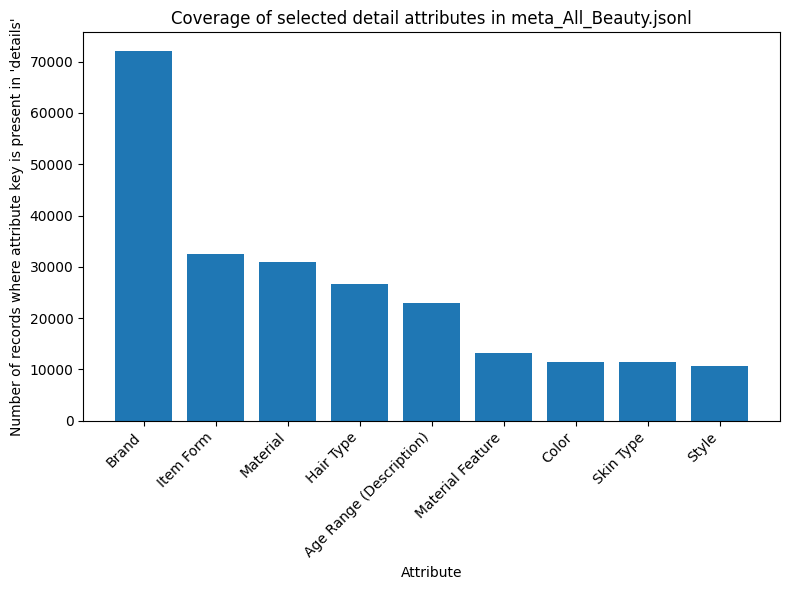

Total records processed: 112590
Attribute coverage counts:
  Brand: 72113
  Item Form: 32439
  Material: 30942
  Hair Type: 26719
  Age Range (Description): 22929
  Material Feature: 13153
  Color: 11475
  Skin Type: 11454
  Style: 10667


In [ ]:
import json
from collections import Counter
import matplotlib.pyplot as plt


JSONL_PATH = r"meta_All_Beauty.jsonl"


DETAIL_KEYS_OF_INTEREST = [
    "Brand",
    "Item Form",
    "Material",
    "Hair Type",
    "Age Range (Description)",
    "Material Feature",
    "Color",
    "Skin Type",
    "Style",
]

details_counter = Counter()
total_records = 0

# Count how many records contain each 'details' key
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line_num, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError as e:
            print(f"Error parsing line {line_num}: {e}")
            continue

        total_records += 1

        details = obj.get("details")
        if isinstance(details, dict):
            # Count each key in details once per record
            for detail_key in details.keys():
                details_counter[detail_key] += 1

# Extract counts for the attributes we care about
attr_counts = {k: details_counter.get(k, 0) for k in DETAIL_KEYS_OF_INTEREST}

# Sort by count (descending) for nicer plotting
labels = list(attr_counts.keys())
values = list(attr_counts.values())

labels_sorted = [x for _, x in sorted(zip(values, labels), reverse=True)]
values_sorted = sorted(values, reverse=True)

plt.figure(figsize=(8,6 ))
plt.bar(labels_sorted, values_sorted)
plt.ylabel("Number of records where attribute key is present in 'details'")
plt.xlabel("Attribute")
plt.title("Coverage of selected detail attributes in meta_All_Beauty.jsonl")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(f"Total records processed: {total_records}")
print("Attribute coverage counts:")
for k in labels_sorted:
    print(f"  {k}: {attr_counts[k]}")


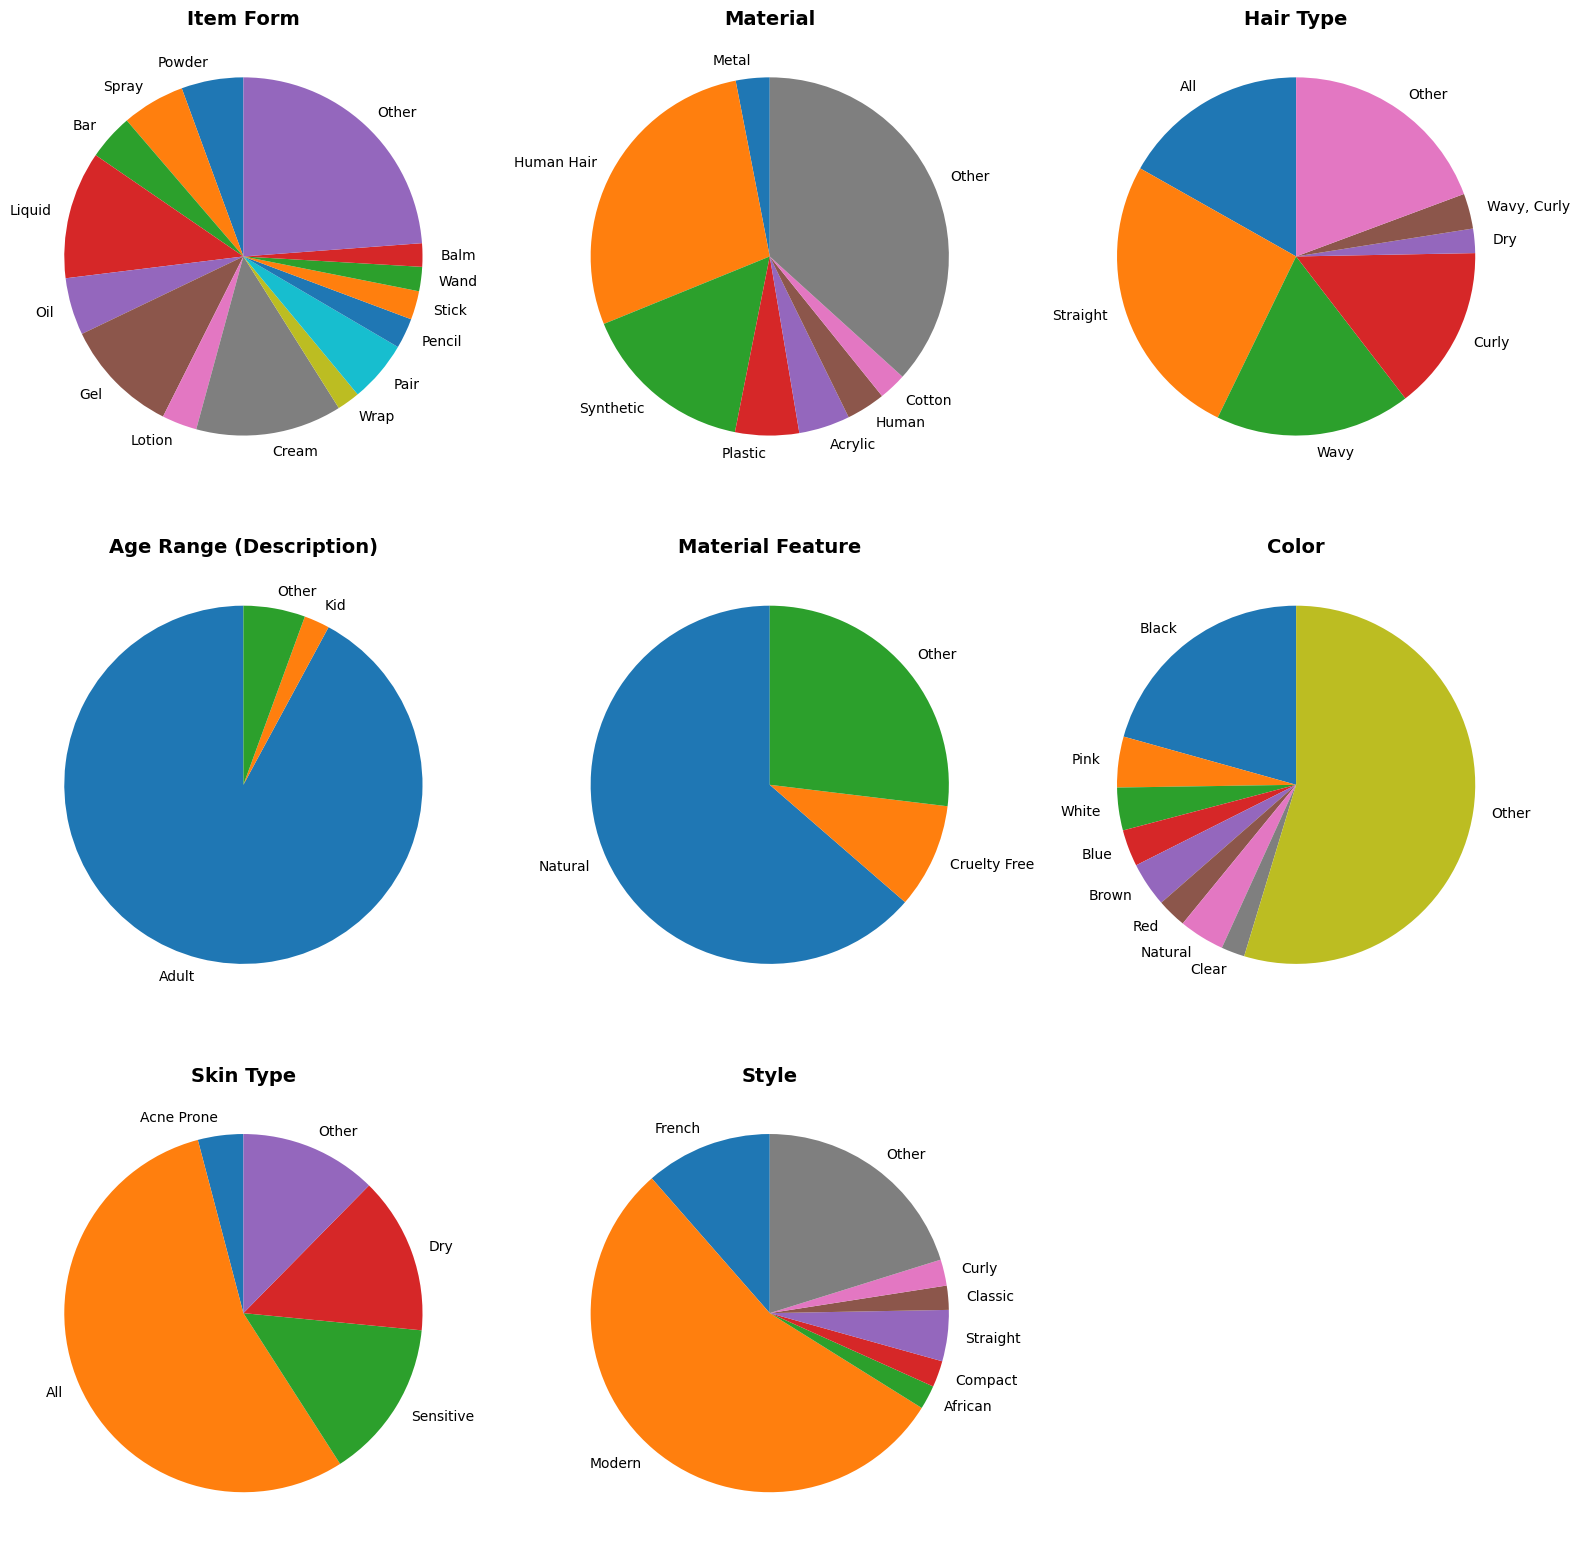

In [ ]:
import json
from collections import Counter
import matplotlib.pyplot as plt


JSONL_PATH = r"meta_All_Beauty.jsonl"

# Attributes for which we want subcategory pies
DETAIL_KEYS_FOR_PIE = [
    "Item Form",
    "Material",
    "Hair Type",
    "Age Range (Description)",
    "Material Feature",
    "Color",
    "Skin Type",
    "Style",
]

# Canonical subcategories (names only — NO hard-coded counts)
TARGET_SUBCATS = {
    "Item Form": [
        "Cream", "Liquid", "Gel", "Pair", "Powder", "Spray", "Oil", "Bar",
        "Lotion", "Pencil", "Stick", "Wand", "Balm", "Wrap", "Scrunchie",
        "Individual", "Elastic", "Sheet", "Clay", "Serum", "Foam", "Wax",
        "Butter", "Clip", "Wipes", "Spiral", "Ribbon", "Mask", "Aerosol", "Strip",
    ],
    "Material": [
        "Human Hair", "Synthetic", "Plastic", "Acrylic", "Human", "Metal",
        "Cotton", "Rubber", "Faux Mink", "Silicone", "Silk", "Ceramic",
        "Nylon", "Polyester", "Mink Fur", "Stainless Steel", "Wood",
        "Acrylonitrile Butadiene Styrene (ABS)", "Plastic, Metal", "Pearl",
        "Elastic", "Cloth", "Acrylonitrile Butadiene Styrene",
        "Faux Mink, Cotton", "Microfiber", "Glass", "Paper", "Aluminum",
        "Resin", "Foam", "Acrylic, Acrylonitrile Butadiene Styrene (ABS)",
    ],
    "Hair Type": [
        "Straight", "Wavy", "All", "Curly", "Wavy, Curly", "Dry",
        "Curly, Straight", "Curly, Kinky", "Kinky", "Color", "Damaged",
        "Thick", "Curly, Coily", "Fine", "Normal", "Frizzy",
        "Wavy, Curly, Straight", "Curly,Wavy",
    ],
    "Age Range (Description)": [
        "Adult", "Kid", "Child", "Baby", "All Ages",
    ],
    "Material Feature": [
        "Natural", "Cruelty Free", "Organic", "Latex Free",
        "Non-Toxic, Cruelty Free", "Gluten Free", "Non-Toxic", "Reusable",
        "Cruelty Free, Vegan", "Vegan", "Organic, Natural",
        "Certified Organic", "Disposable", "Biodegradable Warning",
    ],
    "Color": [
        # Case-insensitive; "black"/"Black"/"BLACK" → "Black", etc.
        "Black", "Pink", "White", "Blue", "Brown", "Red", "Natural",
        "Clear", "Gold", "Silver", "Green", "Purple", "Multicolor", "Beige",
    ],
    "Skin Type": [
        "All", "Sensitive", "Dry", "Acne Prone", "Oily", "Normal", "Combination",
    ],
    "Style": [
        "Modern", "French", "Straight", "Compact", "Curly", "African",
        "Classic", "Art Deco", "Wavy", "Earloop",
    ],
}

# Build lookup tables for case-insensitive matching
SUBCAT_LOOKUPS = {}
for attr, labels in TARGET_SUBCATS.items():
    mapping = {}
    for lab in labels:
        mapping[lab.lower()] = lab  # e.g. "cream" -> "Cream"
    SUBCAT_LOOKUPS[attr] = mapping

# Totals and subcategory counts per attribute
attr_totals = {attr: 0 for attr in DETAIL_KEYS_FOR_PIE}
attr_sub_counts = {attr: Counter() for attr in DETAIL_KEYS_FOR_PIE}

# Scan the JSONL and classify each details[attr] into a subcategory
with open(JSONL_PATH, "r", encoding="utf-8") as f:
    for line_num, line in enumerate(f, 1):
        line = line.strip()
        if not line:
            continue
        try:
            obj = json.loads(line)
        except json.JSONDecodeError as e:
            print(f"Error parsing line {line_num}: {e}")
            continue

        details = obj.get("details")
        if not isinstance(details, dict):
            continue

        for attr in DETAIL_KEYS_FOR_PIE:
            val = details.get(attr)
            if val is None:
                continue
            s = str(val).strip()
            if not s:
                continue

            # Record that this attribute appears on this record
            attr_totals[attr] += 1

            key_lower = s.lower()
            lookup = SUBCAT_LOOKUPS[attr]

            if key_lower in lookup:
                # Only track the subcategories listed; others are "missing" mass
                canonical = lookup[key_lower]
                attr_sub_counts[attr][canonical] += 1
            else:
                # Not in TARGET_SUBCATS → will be counted as "missing" and go to "Other"
                pass

# Build attributes_data so we can reuse the exact same policy as original cell
attributes_data = {
    attr: {
        "total": attr_totals[attr],
        "sub_counts": dict(attr_sub_counts[attr]),
    }
    for attr in DETAIL_KEYS_FOR_PIE
}

# ---- Helper: same policy as original cell ----
def prepare_pie(sub_counts, total=None, merge_case=True, min_pct=0.02):
    """
    sub_counts: dict of {raw_label -> count}
    total: overall count for this attribute (to compute "Other")
    merge_case: if True, 'Black' and 'black' are merged
    min_pct: categories below this share are grouped into 'Other'
    """
    counter = Counter()
    pretty = {}

    for label, count in sub_counts.items():
        key = label.lower() if merge_case else label
        counter[key] += count
        if key not in pretty:
            # Nice human-readable label (first seen)
            pretty[key] = label.title() if merge_case else label

    base = total if total is not None else sum(counter.values())
    labels, values = [], []
    other = 0

    for key, count in counter.items():
        pct = count / base if base > 0 else 0
        if pct >= min_pct:
            labels.append(pretty[key])
            values.append(count)
        else:
            other += count

    # Add any mass not accounted for in sub_counts as "Other" (i.e. categories not in TARGET_SUBCATS)
    if total is not None:
        known_sum = sum(counter.values())
        missing = total - known_sum
        if missing > 0:
            other += missing

    if other > 0:
        labels.append("Other")
        values.append(other)

    return labels, values

# ---- Plot 3x3 grid of pie charts (same size & layout as original) ----
n_attr = len(attributes_data)
rows, cols = 3, 3

plt.figure(figsize=(16, 16))

for i, (attr_name, data) in enumerate(attributes_data.items(), start=1):
    plt.subplot(rows, cols, i)
    labels, values = prepare_pie(
        data["sub_counts"],
        total=data["total"],
        merge_case=True,
        min_pct=0.02,  # same 2% threshold as  original cell
    )
    plt.pie(
        values,
        labels=labels,
        autopct=None,     # ← no percent numbers, same as  snippet
        startangle=90,
        textprops={'fontsize': 10},
    )
    plt.title(attr_name, fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()
